# VIX Prediction

# 1. Introduction

VIX, namely the CBOE Volatility Index, is a popular measure of implied volatility of S&P 500 index options. VIX is often referred to as the “fear index”, with its value spikes during periods of extreme uncertainty. VIX largely reflects future volatility and risk, so it's very valuable for us to predict VIX accurately.

In this project, I utilized some regression methods in machine learning to predict VIX. I retrieved the data from Google Trends APIs, St. Louis Fred websites and ta-lib library. My features can be divided into three parts: google trends, macroeconomic factors and technical factors of VIX and S&P500. (details about all features can be seen in 'dataset_information.csv') 

I did some exploration data analysis, selected some important features and fit data with machine learning methods like Regularized Regression, SVM and Random Forest. I also tried to build a deep learning model LSTM. Finally, I evaluated the performance of each model by comparing MSE and calculating Sharpe Ratio for simulated trading strategies.     

# 2. Retrieving the Data

In [91]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
init_notebook_mode(connected=True)
# from plotly import tools
# import plotly.tools as tls
# import squarify
# from mpl_toolkits.basemap import Basemap
# from numpy import array
# from matplotlib import cm

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()
# from sklearn import preprocessing
# # Supress unnecessary warnings so that presentation looks clean
# import warnings
# warnings.filterwarnings("ignore")

# # Print all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [92]:
#four types of data
df_trend=pd.read_csv('Data/google trend.csv')
df_macro=pd.read_csv('Data/macro.csv')
df_vix=pd.read_csv('Data/vix.csv')
df_spy=pd.read_csv('Data/spy.csv')

In [93]:
print('Size of google trend data', df_trend.shape)
print('Size of macroeconomics data', df_macro.shape)
print('Size of VIX data', df_vix.shape)
print('Size of SPY data', df_spy.shape)

Size of google trend data (5437, 15)
Size of macroeconomics data (6819, 42)
Size of VIX data (3764, 20)
Size of SPY data (3764, 21)


In [94]:
df_trend.columns.values

array(['date', 'volatility', 'crisis', 'risk', 'stock market', 'options',
       'S&P500', 'Investment', 'Momentum', 'Stock', 'Unemployment',
       'travel', 'vacation', 'optimism', 'homeless'], dtype=object)

In [95]:
df_macro.columns.values

array(['date', 'DFF', 'A191RL1Q225SBEA', 'BAMLH0A0HYM2', 'CPIAUCSL',
       'DAAA', 'DCOILWTICO', 'DEXUSEU', 'DGS10', 'DPRIME', 'DTWEXB',
       'DTWEXM', 'EVZCLS', 'GDP', 'GDPC1', 'GOLDAMGBD228NLBM', 'GVZCLS',
       'INDPRO', 'OVXCLS', 'PAYNSA', 'PCE', 'PSAVERT', 'RECPROUSM156N',
       'RU2000PR', 'TEDRATE', 'TERMCBAUTO48NS', 'TOTBKCR', 'TOTCI',
       'TOTLL', 'UNRATE', 'USD3MTD156N', 'USROE', 'VXEEMCLS', 'VXFXICLS',
       'WM1NS', 'WM2NS', 'RU3000TR', 'T10Y2Y', 'T10YFF', 'T5YIFR', 'TB3MS',
       'STLFSI'], dtype=object)

In [96]:
df_vix.columns=['vix_'+i for i in df_vix.columns]
df_vix.columns

Index(['vix_Date', 'vix_Open', 'vix_High', 'vix_Low', 'vix_Close',
       'vix_Adj Close', 'vix_Volume', 'vix_ma5', 'vix_ma20', 'vix_ema5',
       'vix_ema20', 'vix_rsi6', 'vix_rsi12', 'vix_rsi24', 'vix_mom6',
       'vix_mom12', 'vix_mom24', 'vix_roc', 'vix_willr', 'vix_trange'],
      dtype='object')

In [97]:
df_spy.columns=['spy_'+i for i in df_spy.columns]
df_spy.columns

Index(['spy_Date', 'spy_Open', 'spy_High', 'spy_Low', 'spy_Close',
       'spy_Adj Close', 'spy_Volume', 'spy_ma5', 'spy_ma20', 'spy_ema5',
       'spy_ema20', 'spy_rsi6', 'spy_rsi12', 'spy_rsi24', 'spy_mom6',
       'spy_mom12', 'spy_mom24', 'spy_roc', 'spy_willr', 'spy_AD',
       'spy_trange'],
      dtype='object')

# 3. Data Preprocessing

In [98]:
#use first column as index 'date'
df_trend.index=df_trend.iloc[:,0]
df_trend=df_trend.drop('date',axis=1)
df_trend.index=pd.to_datetime(df_trend.index)
df_trend.head()

,volatility,crisis,risk,stock market,options,S&P500,Investment,Momentum,Stock,Unemployment,travel,vacation,optimism,homeless
date,,,,,,,,,,,,,,
2004-01-01,0.000000,65.430304,86.447670,9.816241,32.035103,0.0,27.608068,7.060427,5.658423,72.807365,143.188715,94.833607,0.000000,7.352366
2004-01-02,7.744633,80.926955,100.593652,11.326432,48.052655,0.0,46.588615,7.942981,6.694472,123.969297,165.689799,121.703129,126.916062,8.884109
2004-01-03,0.000000,79.205105,78.588791,11.137658,45.140373,0.0,39.686598,6.398512,5.180246,100.356098,157.507587,120.122568,0.000000,7.658715
2004-01-04,5.335191,77.483255,92.734773,9.816241,42.956161,0.0,39.686598,5.957235,4.861462,127.904830,171.826458,131.186489,49.356247,9.496806
2004-01-05,10.670383,60.264754,80.160567,8.872372,40.043879,0.0,44.863111,9.046172,7.252345,159.389096,167.735352,153.314331,0.000000,12.866641


In [99]:
df_trend.isnull().sum()

volatility      0
crisis          0
risk            0
stock market    0
options         0
S&P500          0
Investment      0
Momentum        0
Stock           0
Unemployment    0
travel          0
vacation        0
optimism        0
homeless        0
dtype: int64

Google trends don't have missing values.

In [100]:
#use first column as index 'date'
df_macro.index=df_macro.iloc[:,0]
df_macro=df_macro.drop('date',axis=1)
df_macro.index=pd.to_datetime(df_macro.index)
df_macro.head()

,DFF,A191RL1Q225SBEA,BAMLH0A0HYM2,CPIAUCSL,DAAA,DCOILWTICO,DEXUSEU,DGS10,DPRIME,DTWEXB,...,VXEEMCLS,VXFXICLS,WM1NS,WM2NS,RU3000TR,T10Y2Y,T10YFF,T5YIFR,TB3MS,STLFSI
date,,,,,,,,,,,,,,,,,,,,,
2000-03-21,5.81,NaN,5.46,NaN,7.59,28.01,0.9703,6.13,8.75,116.7450,...,NaN,NaN,NaN,NaN,3055.28,-0.37,0.32,NaN,NaN,NaN
2000-03-22,6.02,NaN,5.51,NaN,7.62,27.28,0.9608,6.13,9.00,116.9603,...,NaN,NaN,NaN,NaN,3084.56,-0.37,0.11,NaN,NaN,NaN
2000-03-23,6.04,NaN,5.55,NaN,7.60,27.47,0.9691,6.08,9.00,116.7543,...,NaN,NaN,NaN,NaN,3135.33,-0.44,0.04,NaN,NaN,NaN
2000-03-24,5.98,NaN,5.47,NaN,7.63,27.86,0.9724,6.20,9.00,116.4189,...,NaN,NaN,NaN,NaN,3136.22,-0.44,0.22,NaN,NaN,0.885
2000-03-25,5.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
#use ffill to fill missing values for non-daily data 
df_macro=df_macro.fillna(method='ffill')

#remove features with too many null values
df_macro=df_macro.dropna(thresh = len(df_macro)-2000, axis = 1)
df_macro.isnull().sum()

DFF                    0
A191RL1Q225SBEA       11
BAMLH0A0HYM2           0
CPIAUCSL              11
DAAA                   0
DCOILWTICO             0
DEXUSEU                0
DGS10                  0
DPRIME                 0
DTWEXB                 0
DTWEXM                 0
GDP                   11
GDPC1                 11
GOLDAMGBD228NLBM       0
INDPRO                11
PAYNSA                11
PCE                   11
PSAVERT               11
RECPROUSM156N         11
RU2000PR               0
TEDRATE                0
TERMCBAUTO48NS        41
TOTBKCR                1
TOTCI                  1
TOTLL                  1
UNRATE                11
USD3MTD156N            0
USROE                 11
WM1NS                  6
WM2NS                  6
RU3000TR               0
T10Y2Y                 0
T10YFF                 0
T5YIFR              1017
TB3MS                 11
STLFSI                 3
dtype: int64

In [102]:
#use first column as index 'date'
df_vix.index=df_vix.iloc[:,0]
df_vix=df_vix.drop('vix_Date',axis=1)
df_vix.index=pd.to_datetime(df_vix.index)
df_vix.index.name='date'

#calculate close price and daily return
y_close=df_vix['vix_Adj Close']
y_return=df_vix['vix_Adj Close']/df_vix['vix_Adj Close'].shift(1)-1
y_return=y_return.dropna()

In [103]:
#use first column as index 'date'
df_spy.index=df_spy.iloc[:,0]
df_spy=df_spy.drop('spy_Date',axis=1)
df_spy.index=pd.to_datetime(df_spy.index)
df_spy.index.name='date'

Now we want to predict future VIX index, we will use VIX close price in past k days as our new features. (rolling window)

In [104]:
#moving window
def movingwindow(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [105]:
sequence_length = 2

# convert the vector to a 2D matrix
matrix_vix = movingwindow(y_close, sequence_length)
matrix_vix = np.array(matrix_vix)

print("Data  shape: ", matrix_vix.shape)

Data  shape:  (3763, 2)


In [106]:
#rename past price with 'lag' label
y_close_colname=['VIX_lag'+str(sequence_length-i-1) for i in range(sequence_length)]
vix_close=pd.DataFrame(matrix_vix,index=y_close.index[sequence_length-1:],columns=y_close_colname)

#target values
vix_pred=y_close.shift(-1)     

Since Google Trends start from 2004-01-01, we will use data from all categories from 2004-01-01 to 2018-11-19. 

In [107]:
#combine all dataframes into one dataframe
vix_pred=vix_pred[vix_pred.index>='2004-01-01']
vix_pred=vix_pred[vix_pred.index<='2018-11-19']

df_price=pd.DataFrame(vix_pred)
df_tot=df_price.join(vix_close).join(df_vix.drop('vix_Adj Close',axis=1)).join(df_spy).join(df_trend).join(df_macro)

df_tot.index.name='Date'
df_tot.describe()

,vix_Adj Close,VIX_lag1,VIX_lag0,vix_Open,vix_High,vix_Low,vix_Close,vix_Volume,vix_ma5,vix_ma20,...,USD3MTD156N,USROE,WM1NS,WM2NS,RU3000TR,T10Y2Y,T10YFF,T5YIFR,TB3MS,STLFSI
count,3748.000000,3747.000000,3747.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.0,3744.000000,3729.000000,...,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000,3748.000000
mean,18.372327,18.370729,18.371230,18.468954,19.318573,17.622543,18.371190,0.0,18.371034,18.372924,...,1.694010,9.188231,2209.393730,9657.248079,4366.108143,1.395683,1.754674,2.317383,1.239634,-0.455502
std,8.821176,8.822053,8.822098,8.855637,9.441543,8.246817,8.820921,0.0,8.707912,8.513517,...,1.744477,3.583551,820.255756,2516.613094,1830.846133,0.851245,1.120736,0.342097,1.594899,1.046566
min,9.140000,9.140000,9.140000,9.010000,9.310000,8.560000,9.140000,0.0,9.376000,9.782500,...,0.222850,0.410000,1256.900000,6005.900000,1687.240000,-0.190000,-0.850000,0.430000,0.010000,-1.548000
25%,12.930000,12.930000,12.930000,13.030000,13.500000,12.540000,12.930000,0.0,13.011000,13.194500,...,0.299613,7.890000,1396.900000,7352.800000,2957.827500,0.760000,1.130000,2.147500,0.070000,-1.113000
50%,15.630000,15.630000,15.630000,15.760000,16.469999,15.105000,15.630000,0.0,15.692000,15.702000,...,0.881165,9.130000,1960.200000,9085.650000,3583.145000,1.460000,1.860000,2.400000,0.290000,-0.633000
75%,20.799999,20.799999,20.799999,20.950001,21.972499,19.932500,20.799999,0.0,20.690999,20.698000,...,2.678597,11.860000,2934.600000,11824.300000,5826.810000,2.112500,2.560000,2.530000,1.915000,-0.317000
max,80.860001,80.860001,80.860001,80.739998,89.529999,72.760002,80.860001,0.0,72.916000,65.029000,...,5.725000,15.470000,3935.000000,14297.800000,9079.890000,2.910000,3.870000,3.050000,5.030000,5.265000


In [108]:
df_tot=df_tot.dropna()
df_tot.to_csv('Data/dataset.csv')
df_tot.head()

,vix_Adj Close,VIX_lag1,VIX_lag0,vix_Open,vix_High,vix_Low,vix_Close,vix_Volume,vix_ma5,vix_ma20,...,USD3MTD156N,USROE,WM1NS,WM2NS,RU3000TR,T10Y2Y,T10YFF,T5YIFR,TB3MS,STLFSI
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-06,16.389999,17.709999,16.000000,17.709999,17.709999,15.940000,16.000000,0,17.206,16.2250,...,1.13000,15.47,1307.7,6032.3,2549.31,2.35,3.13,2.49,0.93,-0.306
2004-02-09,15.940000,16.000000,16.389999,16.540001,16.820000,16.120001,16.389999,0,17.062,16.2070,...,1.13000,15.47,1268.3,6073.9,2545.50,2.33,3.08,2.50,0.93,-0.306
2004-02-10,15.390000,16.389999,15.940000,16.410000,16.760000,15.840000,15.940000,0,16.782,16.1630,...,1.13000,15.47,1268.3,6073.9,2559.84,2.31,3.13,2.51,0.93,-0.306
2004-02-11,15.310000,15.940000,15.390000,15.900000,16.160000,15.260000,15.390000,0,16.286,16.0305,...,1.13000,15.47,1268.3,6073.9,2587.02,2.32,3.05,2.45,0.93,-0.306
2004-02-12,15.580000,15.390000,15.310000,15.360000,15.720000,15.230000,15.310000,0,15.806,15.9585,...,1.12188,15.47,1268.3,6073.9,2574.31,2.35,3.08,2.49,0.93,-0.306


# 4. Data Exploration

In [109]:
df_tot=pd.read_csv('dataset.csv')
df_tot.index=df_tot.iloc[:,0]
df_tot=df_tot.drop('Date',axis=1)
df_tot.index=pd.to_datetime(df_tot.index)
df_tot.columns

Index(['vix_Adj Close', 'VIX_lag1', 'VIX_lag0', 'vix_Open', 'vix_High',
       'vix_Low', 'vix_Close', 'vix_Volume', 'vix_ma5', 'vix_ma20', 'vix_ema5',
       'vix_ema20', 'vix_rsi6', 'vix_rsi12', 'vix_rsi24', 'vix_mom6',
       'vix_mom12', 'vix_mom24', 'vix_roc', 'vix_willr', 'vix_trange',
       'spy_Open', 'spy_High', 'spy_Low', 'spy_Close', 'spy_Adj Close',
       'spy_Volume', 'spy_ma5', 'spy_ma20', 'spy_ema5', 'spy_ema20',
       'spy_rsi6', 'spy_rsi12', 'spy_rsi24', 'spy_mom6', 'spy_mom12',
       'spy_mom24', 'spy_roc', 'spy_willr', 'spy_AD', 'spy_trange',
       'volatility', 'crisis', 'risk', 'stock market', 'options', 'S&P500',
       'Investment', 'Momentum', 'Stock', 'Unemployment', 'travel', 'vacation',
       'suicide', 'optimism', 'homeless', 'SP500', 'DFF', 'A191RL1Q225SBEA',
       'BAMLH0A0HYM2', 'CPIAUCSL', 'DAAA', 'DCOILWTICO', 'DEXUSEU', 'DGS10',
       'DPRIME', 'DTWEXB', 'DTWEXM', 'GDP', 'GDPC1', 'GOLDAMGBD228NLBM',
       'INDPRO', 'PAYNSA', 'PCE', 'PSAVERT', 

We will do some simple data exploration for each type of data.

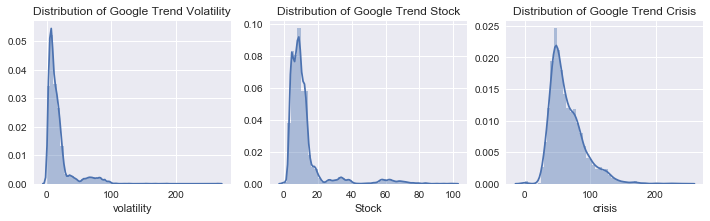

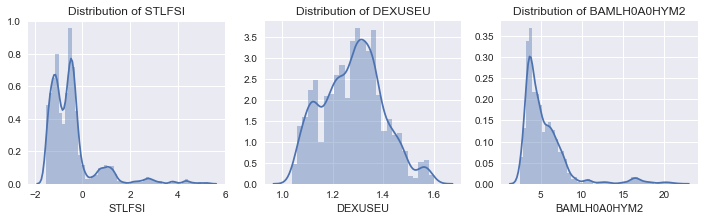

In [110]:
#distribution of several google trends 
%matplotlib inline
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Distribution of Google Trend Volatility")
sns.distplot(df_tot["volatility"])

plt.subplot(1,3,2)
plt.title("Distribution of Google Trend Stock")
sns.distplot(df_tot['Stock'])

plt.subplot(1,3,3)
plt.title("Distribution of Google Trend Crisis")
sns.distplot(df_tot['crisis'])

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Distribution of STLFSI")
sns.distplot(df_tot["STLFSI"])

plt.subplot(1,3,2)
plt.title("Distribution of DEXUSEU")
sns.distplot(df_tot["DEXUSEU"])

plt.subplot(1,3,3)
plt.title("Distribution of BAMLH0A0HYM2")
sns.distplot(df_tot['BAMLH0A0HYM2'])

As we can see, many google trends have a long right tail distribution. 

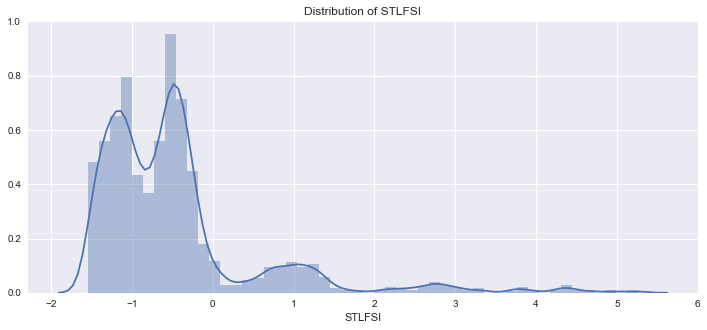

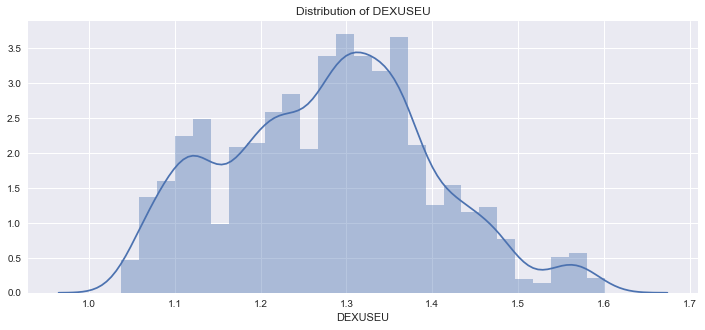

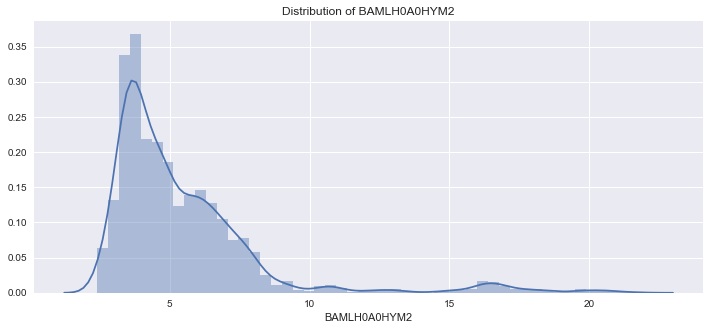

In [111]:
#distribution of several macroeconomics factors
%matplotlib inline
plt.figure(figsize=(12,5))
plt.title("Distribution of STLFSI")
sns.distplot(df_tot["STLFSI"])

plt.figure(figsize=(12,5))
plt.title("Distribution of DEXUSEU")
sns.distplot(df_tot["DEXUSEU"])

plt.figure(figsize=(12,5))
plt.title("Distribution of BAMLH0A0HYM2")
sns.distplot(df_tot['BAMLH0A0HYM2'])

Distributions of macro factors are different, but many of them have long right tails.

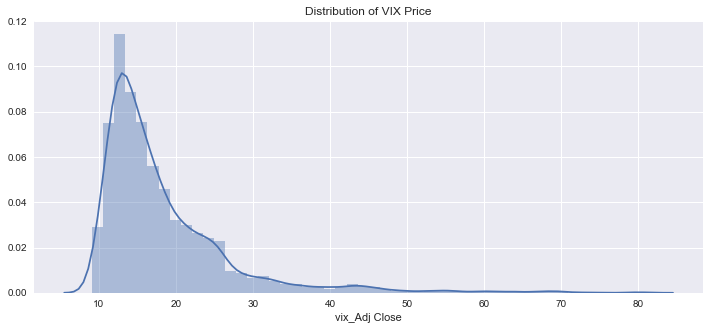

In [112]:
#distribution of VIX price
%matplotlib inline
plt.figure(figsize=(12,5))
plt.title("Distribution of VIX Price")
sns.distplot(df_tot["vix_Adj Close"])

We can see that VIX distribution has a long right tail.

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



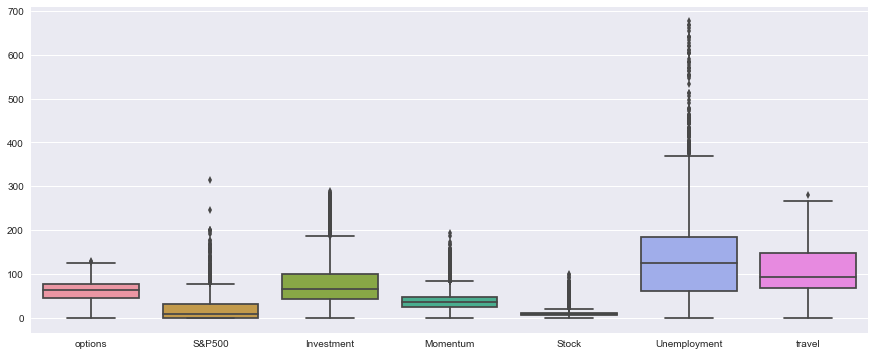

In [113]:
#Boxplots for several google trends
f, ax = plt.subplots(figsize=(15, 6))
fig = sns.boxplot(data=df_tot.iloc[:,45:52])

Some google trends, like "Unemployment", have very high volatility. These features may be not stable for prediction.

C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



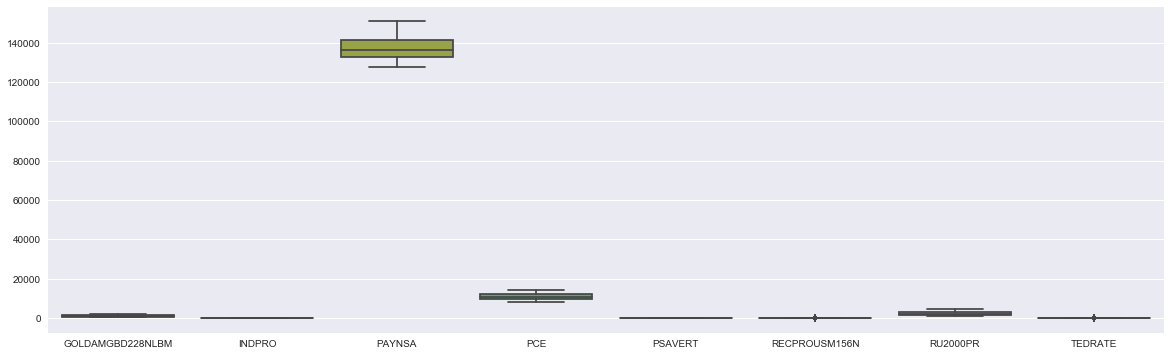

In [114]:
#Boxplots for several macroeconomics factors
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(data=df_tot.iloc[:,70:78])

Some macroeconomics features, like 'PSAVERT', have very low volatility. Maybe they can't reflect the change of VIX.  

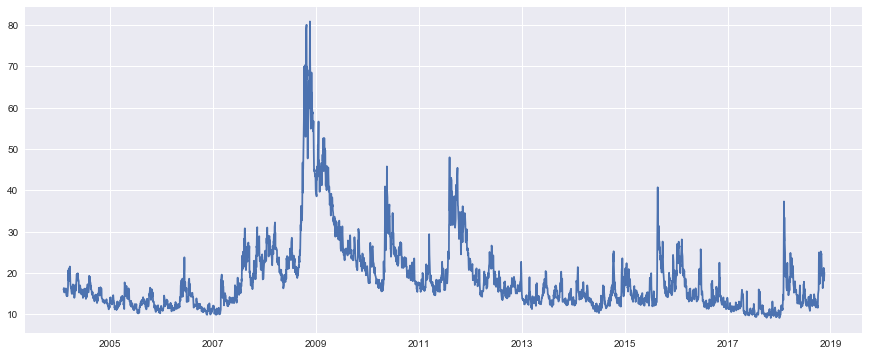

In [115]:
#several curves for google trends
plt.figure(figsize=(15,6))
plt.plot(df_tot.iloc[:,2])

In [116]:
df_X = df_tot.drop('vix_Adj Close', 1)
df_y = df_tot['vix_Adj Close']

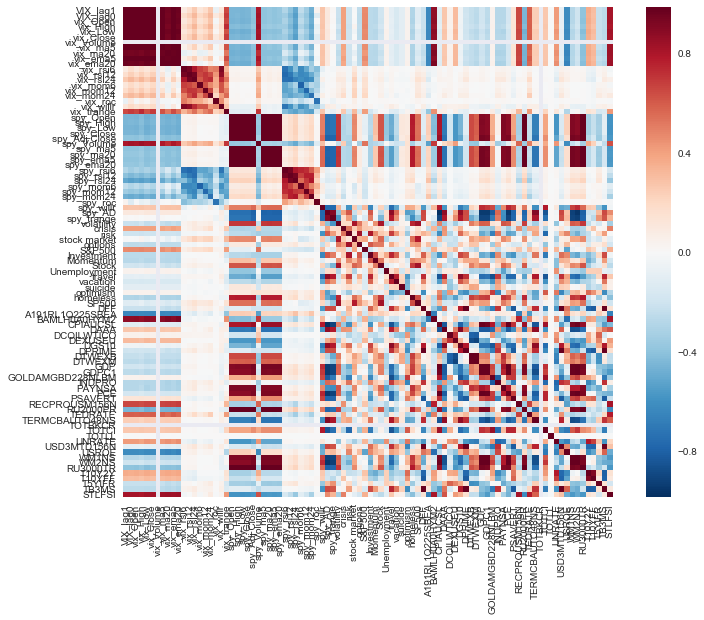

In [117]:
#correlation matrix(heat map)
corrmat = df_X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

As we can see, correlations among VIX technical factors and among some google trends are very high. Correlations between different types of factors tend to be low. We maybe have to eliminate some redundant features of technical factors and google trends.


To select features with an automatic method (not manually), I use random forest to select all features with feature importance larger than 0.01.

In [118]:
#find feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth=4, min_samples_leaf=4, max_features=0.1)
rf.fit(df_X, df_y)
features =df_X.columns.values

In [119]:
#plot feature importance 
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse = False)))
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

We need to drop features with importance less than 0.01.

In [120]:
df_total=df_tot.copy()
for i in range(len(x)):
    if x[i]<0.01:
        df_total=df_total.drop(y[i],axis=1)
df_total.head()

,vix_Adj Close,VIX_lag1,VIX_lag0,vix_Open,vix_High,vix_Low,vix_Close,vix_ma5,vix_ma20,vix_ema5,vix_ema20,spy_Open,spy_Adj Close,spy_ma5,spy_ema5,A191RL1Q225SBEA,BAMLH0A0HYM2,RECPROUSM156N,STLFSI
Date,,,,,,,,,,,,,,,,,,,
2004-02-06,16.389999,17.709999,16.000000,17.709999,17.709999,15.940000,16.000000,17.206,16.2250,16.900486,16.519726,113.419998,85.200462,84.601933,84.683562,2.3,4.34,0.1,-0.306
2004-02-09,15.940000,16.000000,16.389999,16.540001,16.820000,16.120001,16.389999,17.062,16.2070,16.730323,16.507371,114.669998,85.222809,84.677866,84.863311,2.3,4.28,0.1,-0.306
2004-02-10,15.390000,16.389999,15.940000,16.410000,16.760000,15.840000,15.940000,16.782,16.1630,16.466882,16.453336,114.279999,85.498230,84.837175,85.074951,2.3,4.24,0.1,-0.306
2004-02-11,15.310000,15.940000,15.390000,15.900000,16.160000,15.260000,15.390000,16.286,16.0305,16.107921,16.352066,114.849998,86.406441,85.316592,85.518781,2.3,4.31,0.1,-0.306
2004-02-12,15.580000,15.390000,15.310000,15.360000,15.720000,15.230000,15.310000,15.806,15.9585,15.841948,16.252822,115.970001,86.093803,85.684349,85.710455,2.3,4.19,0.1,-0.306


In [121]:
#split dataset
from sklearn.cross_validation import train_test_split

df_X = df_total.drop('vix_Adj Close', 1)
df_y=df_total['vix_Adj Close']
split = int(df_X.shape[0]*0.9)
y_train = df_y.iloc[:split]
y_test = df_y.iloc[split:]
X_train = df_X.iloc[:split]
X_test = df_X.iloc[split:]


Many feature values are very volatile, so we will transform all feature values into scaled values. 

In [122]:
# scale all the feature values
from sklearn.preprocessing import MinMaxScaler

x_scaler=MinMaxScaler()
X_train_scaled=x_scaler.fit_transform(X_train)
X_test_scaled=x_scaler.transform(X_test)

y_scaler=MinMaxScaler()
y_train_scaled=y_scaler.fit_transform(pd.DataFrame(y_train))
y_test_scaled=y_scaler.transform(pd.DataFrame(y_test))

y_train_scaled=np.squeeze(y_train_scaled)
y_test_scaled=np.squeeze(y_test_scaled)

# 5.Machine Learning Models 

## 5.1 Regularized Linear Regression

Use Elastic Net to involve Ridge and Lasso regression.

In [123]:
from sklearn.linear_model import ElasticNet
#plot MSE curves for training and test sets with different parameters
from sklearn.metrics import mean_squared_error
scaled_l=[]
mat=[]
para_list1= [0.001,0.01,0.1,1]
para_list2= np.array(range(6))/5

for i in para_list1:
    for j in para_list2:
        model = ElasticNet(alpha = i,l1_ratio=j)
        model.fit(X_train_scaled,y_train_scaled)
        y_predict=model.predict(X_test_scaled)
        scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    mat.append(scaled_l)
    scaled_l=[]    

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning:

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



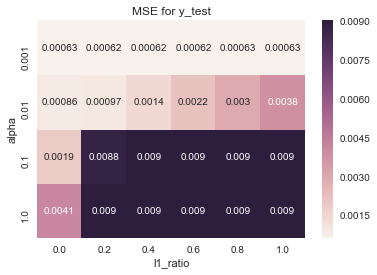

In [124]:
#find best parameters with heatmap
df1 = pd.DataFrame(mat)
df1.index=para_list1
df1.columns=para_list2
sns.heatmap(df1, annot=True)
plt.title('MSE for y_test')
plt.ylabel('alpha')
plt.xlabel('l1_ratio')

MSE:3.12989215334


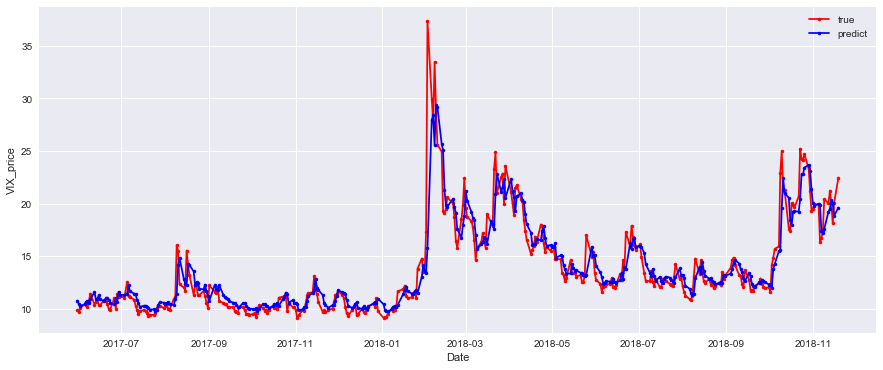

In [125]:
# get the predicted values from the model with the lowest MSE
para_index=list(np.where(df1.values==np.min(df1.values)))
para=[para_list1[int(para_index[0])],para_list2[int(para_index[1])]]

model_Elastic = ElasticNet(alpha = para[0],l1_ratio=para[1])
model_Elastic.fit(X_train_scaled,y_train_scaled)
predicted_values = model_Elastic.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.2 KNN

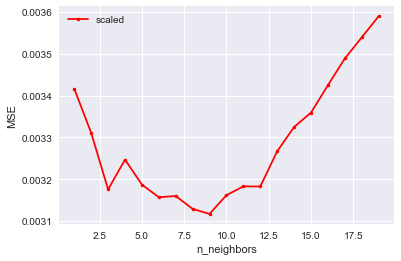

In [126]:
from sklearn.neighbors import KNeighborsRegressor

#plot MSE curves for training and test sets with different parameters

scaled_l=[]
para_list=range(1,20)

for i in para_list:
    model = KNeighborsRegressor(n_neighbors = i)
    model.fit(X_train_scaled,y_train_scaled)
    y_predict=model.predict(X_test_scaled)
    scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    
plt.plot(para_list,scaled_l,'.r-',label='scaled')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('MSE')

MSE:15.7526263991


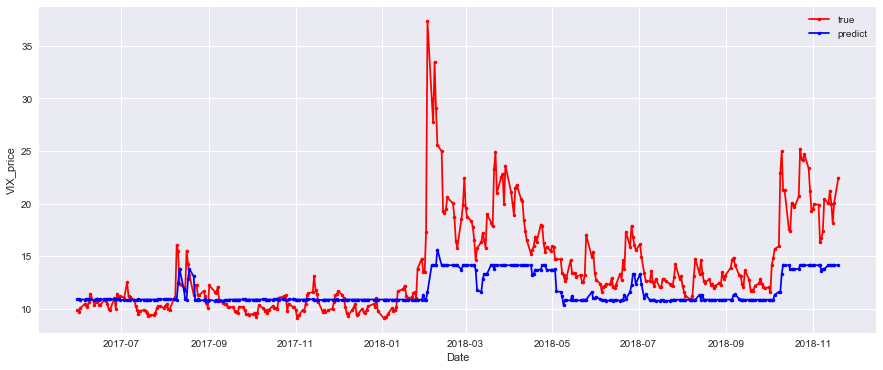

In [128]:
# get the predicted values from the model with the lowest MSE
para_index=scaled_l.index(min(scaled_l))
para=para_list[para_index]

model_KNN = KNeighborsRegressor(n_neighbors = para)
model_KNN.fit(X_train_scaled,y_train_scaled)
predicted_values = model_KNN.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.3 Support Vector Machine

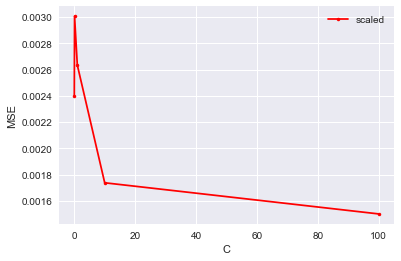

In [129]:
from sklearn.svm import SVR

#plot MSE curves for training and test sets with different parameters

scaled_l=[]
para_list=[0.01,0.1,1,10,100]

for i in para_list:
    model = SVR(kernel="linear",C=i)
    model.fit(X_train_scaled,y_train_scaled)
    y_predict=model.predict(X_test_scaled)
    scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    
plt.plot(para_list,scaled_l,'.r-',label='scaled')
plt.legend()
plt.xlabel('C')
plt.ylabel('MSE')

MSE:10.0378459864


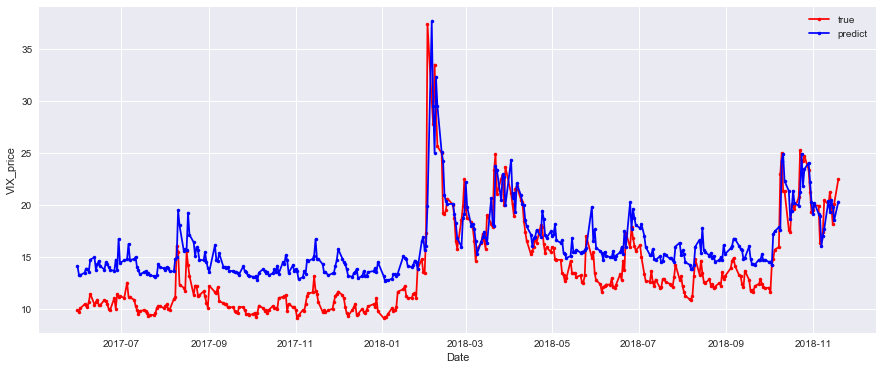

In [131]:
# get the predicted values from the model with the lowest MSE
para_index=scaled_l.index(min(scaled_l))
para=para_list[para_index]

model_SVM = SVR(C=para)
model_SVM.fit(X_train_scaled,y_train_scaled)
predicted_values = model_SVM.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.4 Decision Tree

In [132]:
from sklearn.tree import DecisionTreeRegressor

#plot train and test accuracy curves for different parameters

scaled_l=[]
mat=[]
para_list1= range(2,10)
para_list2= range(2,8)

for i in para_list1:
    for j in para_list2:
        model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j,random_state=43)
        model.fit(X_train_scaled,y_train_scaled)
        y_predict=model.predict(X_test_scaled)
        scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    mat.append(scaled_l)
    scaled_l=[]    

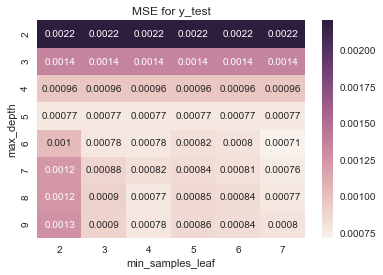

In [133]:
#find best parameters
df1 = pd.DataFrame(mat)
df1.index=para_list1
df1.columns=para_list2
sns.heatmap(df1, annot=True)
plt.title('MSE for y_test')
plt.ylabel('max_depth')
plt.xlabel('min_samples_leaf')

MSE:3.60498138135


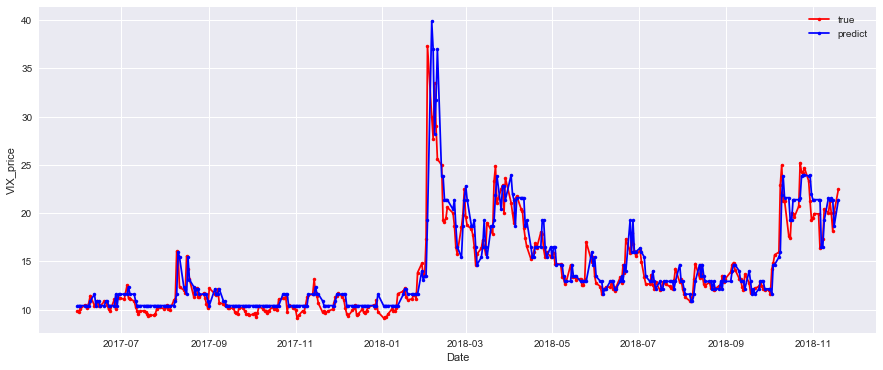

In [135]:
# get the predicted values from the model with the lowest MSE
para_index=list(np.where(df1.values==np.min(df1.values)))
para=[para_list1[int(para_index[0])],para_list2[int(para_index[1])]]

model_Tree = DecisionTreeRegressor(max_depth=para[0], min_samples_leaf=para[1],random_state=43)
model_Tree.fit(X_train_scaled,y_train_scaled)
predicted_values = model_Tree.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.5 Random Forest

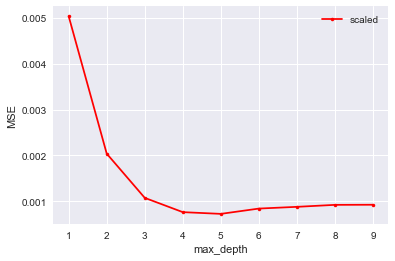

In [136]:
from sklearn.ensemble import RandomForestRegressor

#plot MSE curves for training and test sets with different parameters

scaled_l=[]
para_list=range(1,10)

for i in para_list:
    model = RandomForestRegressor(n_estimators=200, max_depth=i, random_state=43)
    model.fit(X_train_scaled,y_train_scaled)
    y_predict=model.predict(X_test_scaled)
    scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    
plt.plot(para_list,scaled_l,'.r-',label='scaled')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('MSE')

MSE:3.67014618621


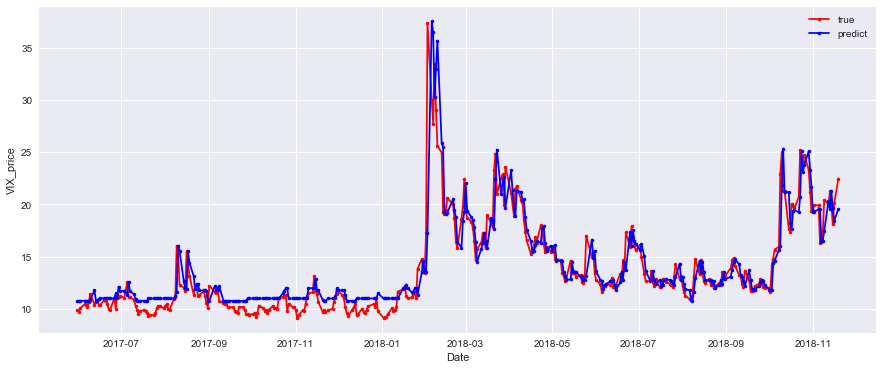

In [138]:
# get the predicted values from the model with the lowest MSE
para_index=scaled_l.index(min(scaled_l))
para=para_list[para_index]

model_RF = RandomForestRegressor(n_estimators=200, max_depth=para, random_state=43)
model_RF.fit(X_train_scaled,y_train_scaled)
predicted_values = model_RF.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.6 Gradient Boosting

In [139]:
from sklearn.ensemble import GradientBoostingRegressor

#plot train and test accuracy curves for different parameters
scaled_l=[]
mat=[]
para_list1=[0.01, 0.1, 0.5, 1]
para_list2=range(1,8)

for i in para_list1:
    for j in para_list2:
        model = GradientBoostingRegressor(n_estimators=200, learning_rate=i, max_depth=j, random_state=42)
        model.fit(X_train_scaled,y_train_scaled)
        y_predict=model.predict(X_test_scaled)
        scaled_l.append(mean_squared_error(y_predict,y_test_scaled))
    mat.append(scaled_l)
    scaled_l=[]    

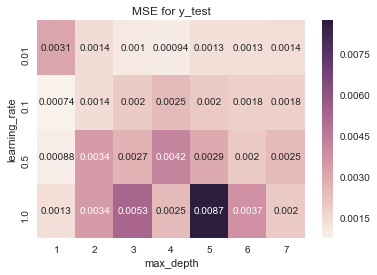

In [140]:
#find best parameters
df1 = pd.DataFrame(mat)
df1.index=para_list1
df1.columns=para_list2
sns.heatmap(df1, annot=True)
plt.title('MSE for y_test')
plt.ylabel('learning_rate')
plt.xlabel('max_depth')

So we choose GradientBoostingRegressor(n_estimators=200, learning_rate=1, max_depth=1, random_state=42) as our model. 

MSE:3.76244559806


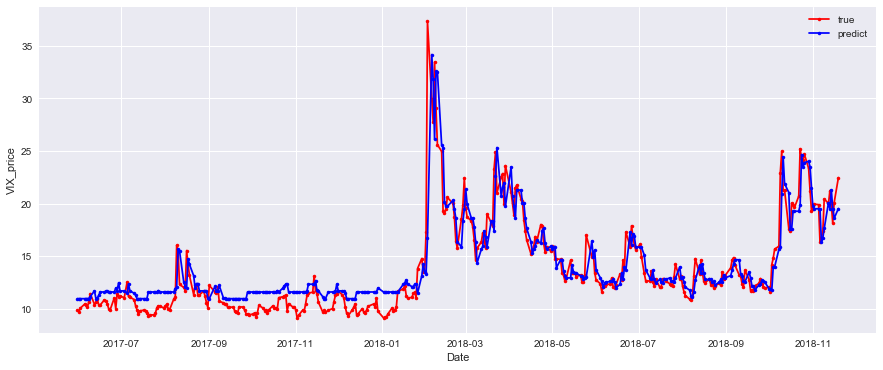

In [141]:
# get the predicted values from the model with the lowest MSE
para_index=list(np.where(df1.values==np.min(df1.values)))
para=[para_list1[int(para_index[0])],para_list2[int(para_index[1])]]

model_GB = GradientBoostingRegressor(n_estimators=200, learning_rate=para[0], max_depth=para[1], random_state=42)
model_GB.fit(X_train_scaled,y_train_scaled)
predicted_values = model_GB.predict(X_test_scaled)
y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

## 5.7 RNN-LSTM

In [142]:
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import backend as K

In [143]:
# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_trainn = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_testn = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_trainn.shape

(3351, 18, 1)

In [144]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(input_shape=(X_trainn.shape[1],1), units=125, return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
# layer 4: dense
# linear activation: a(x) = x
model.add(Dense(units=1,activation='linear'))
# compile the model
model.compile(loss='MSE', optimizer="adam")

In [145]:
# train the model
model.fit(X_trainn, y_train_scaled, batch_size=100, epochs=20, verbose=1)

Epoch 1/20
3351/3351 [==============================] - 25s 8ms/step - loss: 0.0074
Epoch 2/20
3351/3351 [==============================] - 10s 3ms/step - loss: 0.0013
Epoch 3/20
3351/3351 [==============================] - 10s 3ms/step - loss: 0.0010
Epoch 4/20
3351/3351 [==============================] - 9s 3ms/step - loss: 8.8660e-04
Epoch 5/20
3351/3351 [==============================] - 9s 3ms/step - loss: 8.8153e-04
Epoch 6/20
3351/3351 [==============================] - 10s 3ms/step - loss: 8.5765e-04
Epoch 7/20
3351/3351 [==============================] - 10s 3ms/step - loss: 8.6810e-04
Epoch 8/20
3351/3351 [==============================] - 9s 3ms/step - loss: 7.6690e-04
Epoch 9/20
3351/3351 [==============================] - 12s 4ms/step - loss: 8.1256e-04
Epoch 10/20
3351/3351 [==============================] - 10s 3ms/step - loss: 7.3917e-04
Epoch 11/20
3351/3351 [==============================] - 9s 3ms/step - loss: 7.7523e-04
Epoch 12/20
3351/3351 [=======================

MSE:4.11725238724


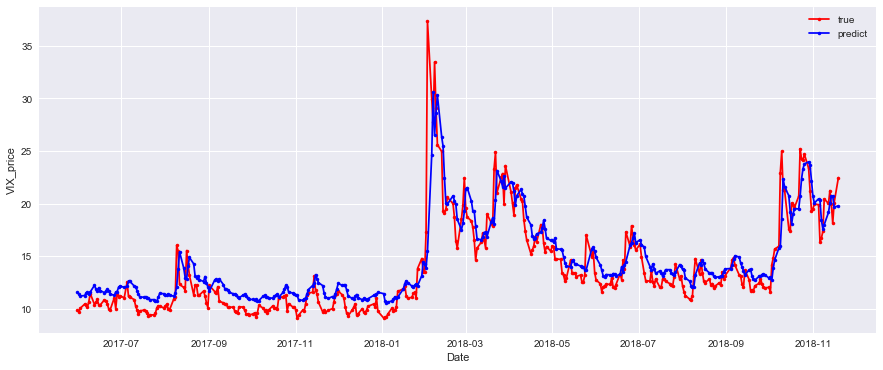

In [146]:
predicted_values = model.predict(X_testn)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

y_pred_rescaled = y_scaler.inverse_transform(predicted_values)

# plot the results
fig = plt.figure(figsize=(15,6))
plt.plot(y_test.index,y_test,'.r-',label='true')
plt.plot(y_test.index,y_pred_rescaled,'.b-',label='predict')

plt.legend()
plt.xlabel('Date')
plt.ylabel('VIX_price')
print('MSE:'+str(mean_squared_error(y_pred_rescaled,y_test)))

# 6. Trading Strategy 

Although we can not trade the VIX Index directly, we could trade some derivatives of VIX Index following the index, such as iPath S&P 500 VIX Short-Term Futures ETN VXX. Considering transaction costs, we can design a simple trading strategy with three parts: '1' means long, '0' means empty, '-1' means short. 

In [147]:
#convert into 3 classes according to daily return
# assume transaction cost is 0.5%

def classify(y_return):
    if y_return>0.005:
        return 1
    elif y_return<-0.005:
        return -1
    else:
        return 0

We will draw PnL curves for all the machine learning models with the best parameters above. Then calculate Information Ratio as a simple measure for trading performance.

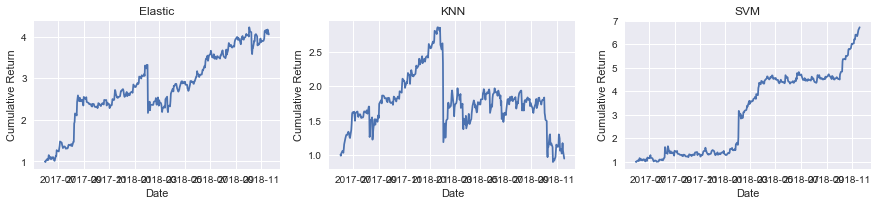

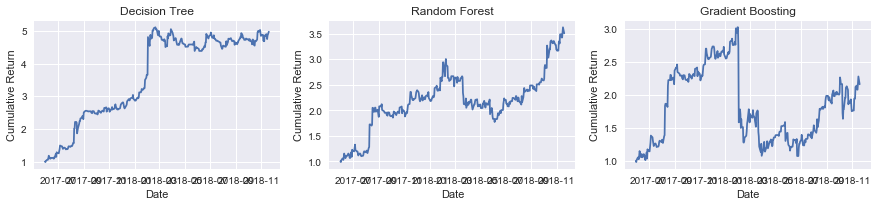

In [152]:
#draw PnL curves
models=[model_Elastic,model_KNN,model_SVM,model_Tree,model_RF,model_GB]
models_name=['Elastic','KNN','SVM','Decision Tree','Random Forest','Gradient Boosting']
IR=[]


for i in range(len(models)):
    models[i].fit(X_train_scaled,y_train_scaled)
    predicted_values = models[i].predict(X_test_scaled)
    y_pred_rescaled = y_scaler.inverse_transform(pd.DataFrame(predicted_values))

    totalpnl=np.zeros(len(y_pred_rescaled))
    totalpnl[0]=1    #initial amount
    dailypnl=[]
    
    #calculate daily PnL
    for j in range(0,len(y_pred_rescaled)-1):
        y_ret=y_pred_rescaled[j+1]/y_test[j]-1
        position=classify(y_ret)
        dailypnl.append(position*(y_test[j+1]/y_test[j]-1))
        totalpnl[j+1]=dailypnl[-1]+totalpnl[j]
    
    if i%3==0:
        plt.figure(figsize=(15,6))
    plt.subplot(2,3,i%3+1)
    plt.plot(y_test.index,totalpnl,label='model'+str(i))
    plt.title(models_name[i])
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    
    IR.append(np.mean(dailypnl)/np.std(dailypnl)*np.sqrt(252))

In [153]:
# Information Ratio for test sets
IR

[1.3316095136602912,
 -0.023364451645779299,
 2.4227817766562656,
 1.7832790376839371,
 1.3952537941503314,
 0.49377622534877408]

# 7.Conclusion

From the perspective of VIX prediction, ElasticNet(alpha = 0.001, l1_ratio=0.6) gives the lowest MSE 3.11. Random Forest, Decision Tree and LSTM are also suitable models with MSE lower than 4. However, KNN and SVM work poorly. 

From the perspective of trading, SVM gives the best Information Ratio, which means trading profit is a different measure of performance other than mean squared error.

Since this project is focused on predicting VIX accurately, regularized linear regression is the best choice. However, I think LSTM will present the best result if I can set better hyper-parameters. Since I'm not proficient in deep learning, I will try to learn more and improve the model in the future.

Also, feature engineering is very important. Most of my features came from many books and papers, which are highly correlated with stock market volatility. I utilized boxplots, histograms and random forest model to select the best features and avoid noise. In the future, I need to find better features and transform all the features into more suitable forms for training.  